<a href="https://colab.research.google.com/github/MECAI2022/short_text_classification/blob/main/ShortTextClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loads iniciais

In [ ]:
#Data manipulation
import pandas as pd
import numpy as np

#Data viz
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams.update({
    'figure.figsize': (16,8)})
import seaborn as sns

#Manipulação de textos
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

# Machine learning e metricas
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Funções auxiliares

## Matriz de confusão multi-label

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
def plot_confusion_matrix(y_true, y_pred, labels=None, show=False):
    columns = 3
    rows = 3
    fig = plt.figure(figsize=(16, 12))
    fig.suptitle('Matriz de confusão', fontsize=20)
    confusion_array = multilabel_confusion_matrix(y_true, y_pred)
    for idx,conf in enumerate(confusion_array):
        ax = fig.add_subplot(rows, columns, idx+1)
        ax.title.set_text(labels[idx])
        probs = conf / conf.sum(axis=1, keepdims=True)
        sns.heatmap(probs,
                    cmap="YlGnBu", linewidths=.5, annot=True, fmt=".1%",
                    xticklabels=['Sim', 'Não'],
                    yticklabels=['Sim', 'Não'],
                    cbar=False).figure.show()
#    plt.savefig(f'{args.confusion_matrix_chart_file}')
    if show:
        plt.show()

# Carregamento e pre-processamento dos dados

In [ ]:
# Para essa célula funcionar crie um atalho da pasta "MAI5003 - Short text classification (Classificação de Produtos)" para seu Drive local.

filepath = "/content/drive/MyDrive/MAI5003 - Short text classification (Classificação de Produtos)/dataset_produtos.xlsx"

df = pd.read_excel(filepath)

/usr/local/lib/python3.7/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [ ]:
df.head()

,nm_item,segmento,categoria,subcategoria,nm_product
0,APRESUNTADO REZENDE PEC KG,1-BENS DE CONSUMO,3-FRIOS E LATICINIOS,6-EMBUTIDOS,APRESUNTADO
1,CARNE SUIN ESPINHACO KG,1-BENS DE CONSUMO,1-ACOUGUE E PEIXARIA,1-ACOUGUE,CARNE SUINA
2,WHISKY WHITE 1LHORSE TRAD.,1-BENS DE CONSUMO,18-BEBIDAS ALCOOLICAS,56-DESTILADOS,WHISKY
3,WHISKY JOHNN WALKER 1L UNRED LABEL.,1-BENS DE CONSUMO,18-BEBIDAS ALCOOLICAS,56-DESTILADOS,WHISKY
4,LTE COND MOCASEMI DESN TP 395G.,1-BENS DE CONSUMO,6-MERCEARIA,22-MERCEARIA LACTEA,LEITE CONDENSADO


In [ ]:
df = df.dropna()
df.isna().mean()

nm_item         0.0
segmento        0.0
categoria       0.0
subcategoria    0.0
nm_product      0.0
dtype: float64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158113 entries, 0 to 158112
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   nm_item       158113 non-null  object
 1   segmento      158113 non-null  object
 2   categoria     158113 non-null  object
 3   subcategoria  158113 non-null  object
 4   nm_product    158113 non-null  object
dtypes: object(5)
memory usage: 7.2+ MB


In [ ]:
df.nunique().sort_values(ascending = True)

segmento             6
categoria           70
subcategoria       153
nm_product         715
nm_item         153445
dtype: int64

## EDA - Olhando as diferentes classes de estratificação

## 1 - Segmento

In [ ]:
df.segmento.unique()

array(['1-BENS DE CONSUMO', '5-HEALTHCARE', '2-CASA E CONSTRUCAO',
       '4-FASHION E ESPORTIVO', '3-ELETROMOVEIS', '6-PETROQUIMICA'],
      dtype=object)

In [ ]:
print(f"Existem {len(df.segmento.unique())} classes diferentes de segmento")

Existem 6 classes diferentes de segmento


In [ ]:
segmento = df.groupby('segmento').size().sort_values(ascending = False)
segmento = segmento.reset_index()
segmento.columns = ['segmento', 'count']
segmento['%'] = (100 * segmento['count'] / segmento['count'].sum()).round(2)
segmento

,segmento,count,%
0,1-BENS DE CONSUMO,152526,96.47
1,2-CASA E CONSTRUCAO,1992,1.26
2,5-HEALTHCARE,1789,1.13
3,4-FASHION E ESPORTIVO,1259,0.80
4,3-ELETROMOVEIS,361,0.23
5,6-PETROQUIMICA,186,0.12


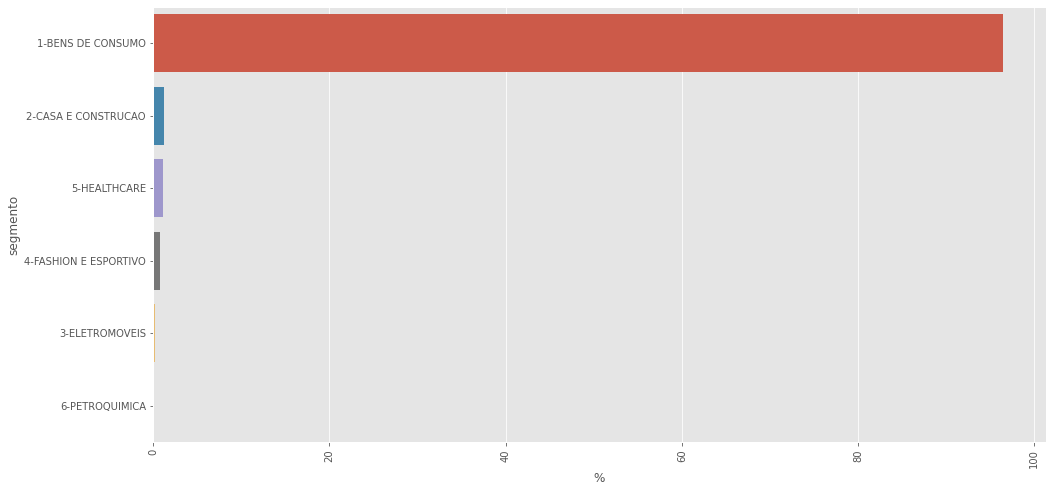

In [ ]:
sns.barplot(data = segmento.head(15), y = 'segmento', x = '%')
plt.xticks(rotation=90);

## 2 - Categoria

In [ ]:
print(f"Existem {len(df.categoria.unique())} classes diferentes de categoria")

Existem 70 classes diferentes de categoria


In [ ]:
df[df['segmento'] == '1-BENS DE CONSUMO'].groupby('categoria').size().sort_values(ascending = False)[:5]

categoria
6-MERCEARIA                  48320
32-PRODUTOS DE LIMPEZA       13834
3-FRIOS E LATICINIOS         13299
31-HIGIENE PESSOAL           12158
8-PREPARADOS E CONGELADOS     7018
dtype: int64

In [ ]:
bens = pd.DataFrame(df[df['segmento'] == '1-BENS DE CONSUMO'].groupby('categoria').size().sort_values(ascending = False))
bens = bens.reset_index()
bens.columns = ['categoria', 'count']
bens['%'] = (100 * bens['count'] / bens['count'].sum()).round(2)
bens.head(10)

,categoria,count,%
0,6-MERCEARIA,48320,31.68
1,32-PRODUTOS DE LIMPEZA,13834,9.07
2,3-FRIOS E LATICINIOS,13299,8.72
3,31-HIGIENE PESSOAL,12158,7.97
4,8-PREPARADOS E CONGELADOS,7018,4.60
5,5-HORTIFRUTI (FLV),6353,4.17
6,1-ACOUGUE E PEIXARIA,6328,4.15
7,7-PADARIA E CONFEITARIA,5716,3.75
8,24-SUCOS E REFRESCOS,5080,3.33
9,18-BEBIDAS ALCOOLICAS,4626,3.03


Text(0.5, 1.0, '15 principais categorias para o segmento Bens de Consumo')

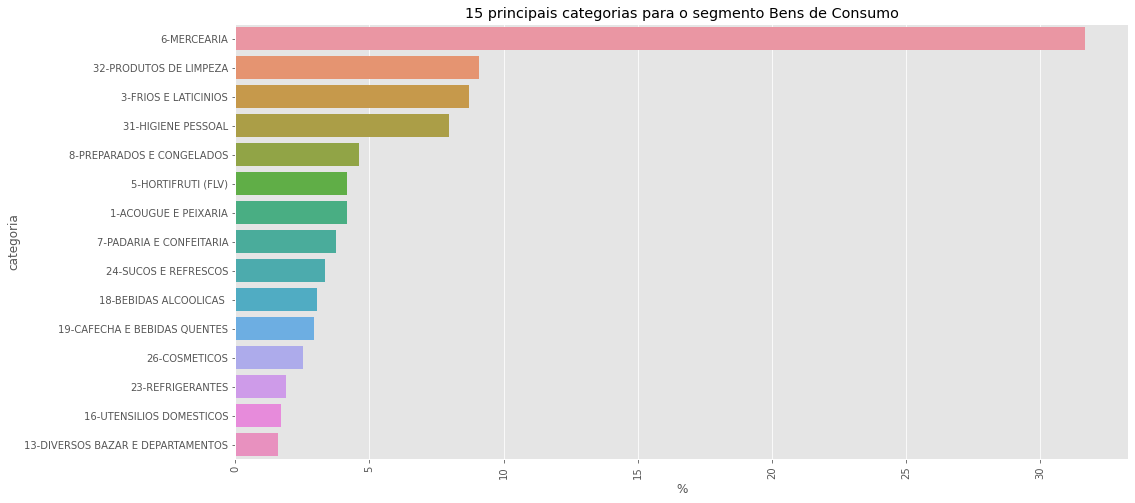

In [ ]:
sns.barplot(data = bens.head(15), y = 'categoria', x = '%')
plt.xticks(rotation=90)
plt.title('15 principais categorias para o segmento Bens de Consumo')

In [ ]:
df[df['segmento'] == '5-HEALTHCARE'].groupby('categoria').size().sort_values(ascending = False)

categoria
72-OUTROS FARMA                   1529
67-ENFERMAGEM E INSTRUMENTACAO     233
68-HOMECARE                         11
76-CLINICAS E LABORATORIOS           5
73-SAUDE ANIMAL                      4
69-HOSPITALARES E CLINICOS           3
75-OUTROS HEALTHCARE                 2
71-MEDICAMENTOS                      1
74-SUPLEMENTOS                       1
dtype: int64

In [ ]:
df[df['segmento'] == '2-CASA E CONSTRUCAO'].groupby('categoria').size().sort_values(ascending = False)

categoria
39-DIVERSOS DECORACAO E JARDIM            924
38-CAMAMESA E BANHO                       464
40-ILUMINACAO                             181
47-BANHEIROCOZINHA E LAVANDERIA           125
41-TAPETES E CORTINAS                      56
46-ACABAMENTO                              53
44-FERRAGENS E FERRAMENTAS                 52
49-ELETRICA                                47
36-AREA DE LAZER                           30
52-PINTURA E VEDACAO                       21
51-HIDRAULICA E GAS                        15
37-ARTIGOS DE DECORACAO                    11
45-DIVERSOS HOME CENTER                     6
43-EQUIPAMENTOS                             4
42-DIVERSOS FERRAMENTAS E EQUIPAMENTOS      3
dtype: int64

## 3 - Subcategoria

In [ ]:
print(f"Existem {len(df.subcategoria.unique())} classes diferentes de subcategoria")

Existem 153 classes diferentes de subcategoria


In [ ]:
df.subcategoria.unique()

array(['6-EMBUTIDOS', '1-ACOUGUE', '56-DESTILADOS', '22-MERCEARIA LACTEA',
       '62-BEBIDAS LACTEAS', '24-PREPAROS E COBERTURAS',
       '86-RACOES E PETISCOS', '73-HIGIENE DO BEBE',
       '75-ACESSORIOS E DESCARTAVEIS', '80-LIMPEZA DOMESTICA',
       '15-CONDIMENTOS', '18-FARINACEOS ', '23-MOLHOS E TEMPEROS DE MESA',
       '68-CUIDADO COM O CORPO ', '55-CERVEJAS', '78-HIGIENE CORPORAL',
       '17-DOCESSALGADOS E BOMBONIERE', '77-HIGIENE CAPILAR',
       '28-CONGELADOS', '76-HIGIENE BUCAL', '8-FUNCIONAIS E RESTRITIVOS',
       '64-SUCOS E REFRESCOS', '7-LATICINIOS REFRIGERADOS',
       '208-RESFRIADOS', '11-LEGUMES', '14-AZEITE E OLEOS ', '59-CHAS',
       '58-CAFE', '170-CURATIVO E BANDAGENS', '79-LAVANDERIA',
       '69-MAQUIAGEM E ESMALTERIA', '63-REFRIGERANTES', '21-MASSAS',
       '20-GRAOS', '65-FERMENTADOS', '4-SAZONAIS',
       '19-ALIMENTOS E FORMULAS INFANTIS', '53-DESCARTAVEIS CASA',
       '35-ARTIGOS PARA FESTA', '61-ENERGETICOS E ISOTONICOS',
       '44-DIVERSOS BAZA

# Teste de modelos

## SVC

In [ ]:
X = df['nm_item']

In [ ]:
documents = []

for i in range(0, len(X)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[i]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    #document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    #document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Converting to Lowercase
    document = document.lower().strip()
    
    documents.append(document)

In [ ]:
documents[:30]

['apresuntado rezende pec kg',
 'carne suin espinhaco kg',
 'whisky white 1lhorse trad',
 'whisky johnn walker 1l unred label',
 'lte cond mocasemi desn tp 395g',
 'beb nestle fast 280mlalpino',
 'achoc po nescau sch2 0 800g',
 'racao frisk 3kgmix de cne sel sab',
 'sab johns baby 80ghora sono',
 'abs sempre livre es adp lv16 pgmenos un',
 'sh johns baby 400mlregular',
 'prot carefree 40unprot perf',
 'limp san harpic 500mllav',
 'limp veja uso 500mlcampest',
 'caldo knorr 19ggal',
 'caldo knorr 57gleg',
 'caldo knorr 57ggal',
 'caldo knorr 114ggal',
 'amido milho maizena cx 200g',
 'amido milho maizena cx 500g',
 'amido milho maizena cx 1kg',
 'maionese hellmanns sch 200g',
 'caldo knorr 57gcostela',
 'caldo knorr 57gbacon louro',
 'maionese hellmanns 250gtrad',
 'maionese hellmanns trad pt 500g',
 'desod aer nivea 150mlblewhit cl',
 'desod nivea 50mlblack white clean',
 'desod aer nivea 150mlblewhit pow',
 'desod nivea 50mlblack white pow']

In [ ]:
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('portuguese'))
X = vectorizer.fit_transform(documents).toarray()

In [ ]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

In [ ]:
X

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.41615648, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
X.shape

(158113, 1500)

In [ ]:
df.shape

(158113, 5)

In [ ]:
pd.get_dummies(df['segmento'])

,1-BENS DE CONSUMO,2-CASA E CONSTRUCAO,3-ELETROMOVEIS,4-FASHION E ESPORTIVO,5-HEALTHCARE,6-PETROQUIMICA
0,1,0,0,0,0,0
1,1,0,0,0,0,0
2,1,0,0,0,0,0
3,1,0,0,0,0,0
4,1,0,0,0,0,0
...,...,...,...,...,...,...
158108,1,0,0,0,0,0
158109,1,0,0,0,0,0
158110,1,0,0,0,0,0
158111,1,0,0,0,0,0


In [ ]:
Y = pd.get_dummies(df['segmento'])

In [ ]:
y = np.array(Y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 0)

In [ ]:
svc = SVC(kernel = 'rbf')
multi_svc = OneVsRestClassifier(svc)

In [ ]:
multi_svc.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC())

In [ ]:
print("F1 validation: ", f1_score(y_test, multi_svc.predict(X_test), average='samples'))
print("F1 training: ", f1_score(y_train, multi_svc.predict(X_train), average='samples'))

F1 validation:  0.9729416353076348
F1 training:  0.9768044904735552


In [ ]:
y_pred = multi_svc.predict(X_test)

###Cross-Validation (para o futuro)

In [ ]:
C_range = [2 ** exp for exp in range(-5, 6)]
gamma_range = [2 ** exp for exp in range(-13, 1)]

In [ ]:
svc = SVC()
multi_svc = OneVsRestClassifier(svc)

tuned_parameters = {'estimator__kernel': ['rbf'],
                    'estimator__gamma': gamma_range,
                    'estimator__C': C_range}

# clf = GridSearchCV(
#         multi_svc,
#         tuned_parameters,
#         scoring='f1_samples',
#         verbose=1,
#         n_jobs=-1
#     )

clf = RandomizedSearchCV(
    estimator=multi_svc, 
    param_distributions=tuned_parameters,
    scoring='f1_samples',
    n_jobs=-1,
    n_iter=10,
    verbose=1
)

%time clf.fit(X_train, y_train)

print("F1 validation: ", f1_score(y_test, clf.predict(X_test), average='samples'))
print("F1 training: ", f1_score(y_train, clf.predict(X_train), average='samples'))
print("Best params: ", clf.best_params_)

# Teste - Matriz de confusão

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
def plot_confusion_matrix(y_true, y_pred, labels=None, show=False):
    columns = 3
    rows = 3
    fig = plt.figure(figsize=(16, 12))
    fig.suptitle('Matriz de confusão', fontsize=20)
    confusion_array = multilabel_confusion_matrix(y_true, y_pred)
    for idx,conf in enumerate(confusion_array):
        ax = fig.add_subplot(rows, columns, idx+1)
        ax.title.set_text(labels[idx])
        probs = conf / conf.sum(axis=1, keepdims=True)
        sns.heatmap(probs,
                    cmap="YlGnBu", linewidths=.5, annot=True, fmt=".1%",
                    xticklabels=['Sim', 'Não'],
                    yticklabels=['Sim', 'Não'],
                    cbar=False).figure.show()
#    plt.savefig(f'{args.confusion_matrix_chart_file}')
    if show:
        plt.show()

In [ ]:
Y.columns

Index(['1-BENS DE CONSUMO', '2-CASA E CONSTRUCAO', '3-ELETROMOVEIS',
       '4-FASHION E ESPORTIVO', '5-HEALTHCARE', '6-PETROQUIMICA'],
      dtype='object')

In [ ]:
labels = ['BENS DE CONSUMO', 'CASA E CONSTRUCAO', 'ELETROMOVEIS', 'FASHION E ESPORTIVO',
          'HEALTHCARE', 'PETROQUIMICA']

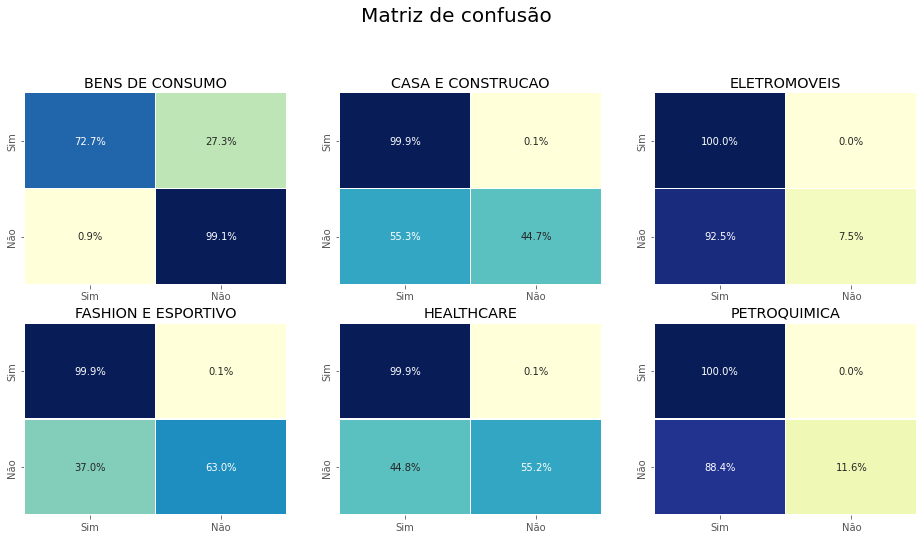

In [ ]:
plot_confusion_matrix(y_test, y_pred, labels)